In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
from numpy.linalg import matrix_power as MP

import scipy
from scipy.spatial.distance import cdist
from scipy.io import savemat, loadmat
from scipy.optimize import Bounds

import networkx as nx
import sys

import tensorflow as tf
from keras.callbacks import EarlyStopping

print(f"TF Version: {tf.__version__}")

TF Version: 2.14.0


In [2]:
X_train_data = ADHD_data = [np.array(d).T for d in loadmat("./Dataset/ADHD_Data.mat")['ADHD_Data'][0, :]]
ADHD_label = [0] * 20 + [1] * 20 # 0 - Control, 1 - ADHD

num_samples = len(X_train_data)
N = X_train_data[0].shape[0]
T_list = [X_train_data[i].shape[1] for i in range(num_samples)]
T = T_list[0]
print(f"Number of Samples: {num_samples}, N: {N}")

Number of Samples: 40, N: 39


In [3]:
X_train_data = [(data - np.mean(data.flatten())) / np.std(data.flatten()) for data in X_train_data]

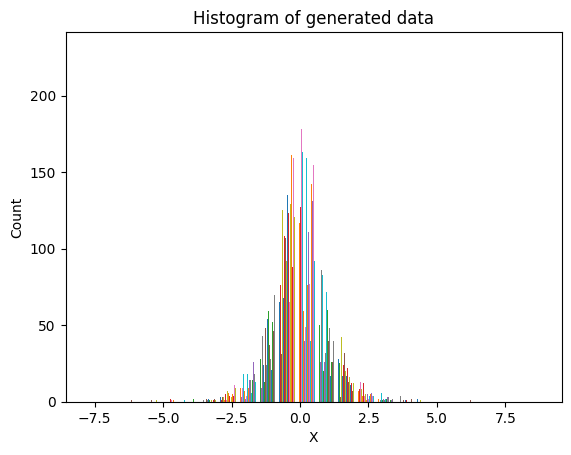

In [4]:
tmp = [list(d.flatten()) for d in X_train_data]
plt.hist(tmp, bins = 'auto')
plt.xlabel("X")
plt.ylabel("Count")
plt.title("Histogram of generated data")
plt.show()

In [5]:
def generate_delta(T):
    diff_matrix = np.zeros([T, T - 1]) - np.eye(T, T - 1)
    for i in range(1, T):
        diff_matrix[i, i - 1] = 1
    return tf.convert_to_tensor(diff_matrix, dtype = "float32")

In [6]:
Mul = np.eye(N) - np.ones([N, N])
Mul = tf.convert_to_tensor(Mul, dtype = "float32")

In [7]:
def initial_graph(X_training, N, top_values = 6):
    distance_matrix = cdist(X_training, X_training, metric = 'euclidean')
    
    sorted_indices = distance_matrix.argsort(1)
    TAdj = np.zeros([N, N])
    
    for i in range(N):
        for j in range(1, top_values):
            k = sorted_indices[i][j]
            TAdj[i][k] = 1
    
    TAdj = (TAdj + TAdj.T) / 2
    TAdj = np.where(TAdj > 0.1, 1, 0)
    
    Laplacian_init = np.diag(np.sum(TAdj, 1)) - TAdj
    
    return Laplacian_init

In [8]:
psi_cost = 0
Laplacian = 0
A_transform_cost = 0

In [9]:
# A - Predicted, B - Target matrix
def costfunc(A, B):
    global psi_cost
    global Laplacian
    global A_transform_cost

    B_tmp = tf.squeeze(B)
    data_fidelity = (tf.norm(tf.multiply(psi_cost, (A - B))) ** 2)
    smoothness = tf.linalg.trace(tf.transpose(B_tmp) @ Laplacian @ B_tmp @ A_transform_cost)
    L_cost = (tf.norm(Laplacian) ** 2)
    Z_cost = (tf.norm(A_transform_cost) ** 2)
    
    return (smoothness) + (data_fidelity) + (L_cost) + (Z_cost)
    
def costfunc1(A, B):
    global psi_cost
    
    data_fidelity = (tf.norm(tf.multiply(psi_cost, (A - B))) ** 2)
    return (data_fidelity)

def costfunc2(A, B):
    global Laplacian
    global A_transform_cost
    
    B_tmp = tf.squeeze(B)
    smoothness = tf.linalg.trace(tf.transpose(B_tmp) @ Laplacian @ B_tmp @ A_transform_cost)
    
    return (smoothness)

def costfunc3(A, B):
    global Laplacian
    
    L_cost = (tf.norm(Laplacian) ** 2)
    
    return (L_cost)

def costfunc4(A, B):
    global A_transform_cost
    
    Z_cost = (tf.norm(A_transform_cost) ** 2)
    
    return (Z_cost)

In [10]:
def forward_pass(X_train_concatenated, X_train, params, p1, p2, d):
    
    def data_inpainting(loop_b, reg, psi, Y, Lk, AAT):

        Xk = tf.zeros_like(Y)
        Zk = -(tf.multiply(psi, Xk) - Y + (2 * reg * (Lk @ Xk @ AAT)))

        for i in range(loop_b):
            fdx_xk = tf.multiply(psi, Xk) - Y + (2 * reg * (Lk @ Xk @ AAT))
            fdx_zk = tf.multiply(psi, Zk) - Y + (2 * reg * (Lk @ Zk @ AAT))
            
            tau = tf.linalg.trace(tf.transpose(fdx_xk) @ Zk) / tf.linalg.trace(tf.transpose((Y + fdx_zk)) @ Zk)
            
            Xk_1 = Xk - (tau * Zk)

            fdx_xk_1 = tf.multiply(psi, Xk_1) - Y + (2 * reg * (Lk @ Xk_1 @ AAT))
            gamma = (tf.norm(fdx_xk_1) ** 2) / (tf.norm(fdx_xk) ** 2)

            Zk_1 = (gamma * Zk) - fdx_xk_1

            Xk = Xk_1
            Zk = Zk_1
        
        return Xk_1
    
    def graph_learning(loop_c, alpha, beta, X, Lk, AAT):
        
        # Computing the smoothness term
        X_AAT_XT = tf.matmul(X, tf.matmul(AAT, tf.transpose(X)))
        
        for i in range(loop_c):

            # Extracting the adjacency matrix from the Laplacian
            adj_i = tf.multiply(Mul, Lk)

            # Computing the gradient with respect to laplacian
            fdL_Lk = X_AAT_XT + (beta * Lk)
            
            # Extracting the adjacency matrix from the gradient
            adj_grad = tf.multiply(Mul, fdL_Lk)
            
            # Computing the new adjacency
            adj_i1 = adj_i - (alpha * adj_grad)
            
            # Avoiding any negative values
            adj_i1 = tf.nn.relu(adj_i1)

            # Computing the new laplacian
            Lk_1 = tf.linalg.diag(tf.math.reduce_sum(adj_i1, 1)) - adj_i1
            
            # Updating the laplacian
            Lk = Lk_1
            
        return Lk
    
    y = X_train_concatenated
    
    psi = y[0,:,T:]
    global psi_cost
    psi_cost = psi

    psi = tf.convert_to_tensor(psi, dtype = "float32")

    X_in = y[0,:,:T]
    X_in = psi * tf.convert_to_tensor(X_in, dtype = "float32")
    Y = X_in
    
    loop_a, loop_b, loop_c, reg, alpha, beta, threshold, Lk = params
    
    LT = tf.matmul(d, tf.transpose(d))
    LT = tf.convert_to_tensor(LT, dtype = "float32")
    
    A_transform = tf.eye(T) + (p1 * MP(LT, 1)) + (p2 * MP(LT, 2))
    AAT = A_transform
    
    global A_transform_cost
    A_transform_cost = AAT
    
    for i in range(loop_a):
            
        Xk_1 = data_inpainting(loop_b, reg, psi, Y, Lk, AAT)

        Xk_1_gt = X_in + tf.multiply((tf.ones(psi.shape) - psi), Xk_1)

        Lk_1 = graph_learning(loop_c, alpha, beta, Xk_1_gt, Lk, AAT)

        Adj = tf.linalg.diag(tf.linalg.diag_part(Lk_1)) - Lk_1

        n = tf.math.count_nonzero(Adj, dtype="float32")
        mean = tf.math.reduce_sum(Adj) / n
        Adj = tf.math.subtract(Adj, (threshold * mean))

        Adj = tf.nn.relu(Adj)
        # Adj = tf.math.sign(Adj)

        Lk_1 = tf.linalg.diag(tf.math.reduce_sum(Adj, 1)) - Adj

        Lk = Lk_1
        
        global Laplacian
        Laplacian = Lk
    
    Xk = data_inpainting(loop_b, reg, psi, Y, Lk, AAT)
    tmp = np.array([costfunc1(X_train, Xk), costfunc2(X_train, Xk), 
                    costfunc3(X_train, Xk), costfunc4(X_train, Xk)])

    return tmp

In [11]:
no_of_psi = 1
# sensing_ratio = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.4, 0.45, 0.5]
# sensing_ratio = (1 + np.arange(50)) / 100
# sensing_ratio = np.arange(1.0, 51.0, 1.0) / 100
sensing_ratio = 0.1

p1, p2 = 8.0, 10.0

loop_a = 5
loop_b = 10
loop_c = 10 
reg_init = 1.0e-2
alpha_init = 1.0e-5
beta_init = 1.0e-2
threshold_init = 0.3

In [12]:
all_psi = []
opt_coeffs = []

print(f"Sensing Ratio: {int(100 * sensing_ratio)}%")

for i in range(num_samples):
    T = T_list[i]
    d = generate_delta(T)
    X_train = X_train_data[i]
    Lap_init = initial_graph(X_train, N)

    params = [loop_a, loop_b, loop_c, reg_init, alpha_init, beta_init, threshold_init, Lap_init]
        
    M = int(sensing_ratio * T)
    X_train_missing = np.zeros([no_of_psi, N, T])
    X_train_concatenated = np.zeros([no_of_psi, N, 2 * T])

    for i in range(no_of_psi):
        psi_k = np.array([0] * (N * M) + [1] * (N * (T - M)))
        np.random.shuffle(psi_k)
        psi_k = psi_k.reshape([N, T])
        all_psi.append(psi_k)
        X_train_missing[i, : , : ] = X_train * psi_k
        X_train_concatenated[i, :, :] = np.concatenate((X_train_missing[i], psi_k), axis = 1)

    Laplacian = 0

    c1_test = forward_pass(X_train_concatenated, X_train, params, p1, p2, d)

    mul = 10 ** (-np.floor(np.log10(c1_test), dtype = "float"))
    print(mul)

    opt_coeffs.append(np.array(mul))
    print(f"The optimal coefficients are:", list(opt_coeffs[-1]), f"\n")

Sensing Ratio: 10%
[1.e-03 1.e-04 1.e-03 1.e-06]
The optimal coefficients are: [0.001, 0.0001, 0.001, 1e-06] 

[1.e-02 1.e-04 1.e-03 1.e-06]
The optimal coefficients are: [0.01, 0.0001, 0.001, 1e-06] 

[1.e-02 1.e-04 1.e-03 1.e-06]
The optimal coefficients are: [0.01, 0.0001, 0.001, 1e-06] 

[1.e-02 1.e-04 1.e-03 1.e-06]
The optimal coefficients are: [0.01, 0.0001, 0.001, 1e-06] 

[1.e-02 1.e-04 1.e-03 1.e-05]
The optimal coefficients are: [0.01, 0.0001, 0.001, 1e-05] 

[1.e-02 1.e-04 1.e-03 1.e-05]
The optimal coefficients are: [0.01, 0.0001, 0.001, 1e-05] 

[1.e-03 1.e-04 1.e-03 1.e-06]
The optimal coefficients are: [0.001, 0.0001, 0.001, 1e-06] 

[1.e-03 1.e-04 1.e-03 1.e-06]
The optimal coefficients are: [0.001, 0.0001, 0.001, 1e-06] 

[1.e-03 1.e-04 1.e-03 1.e-06]
The optimal coefficients are: [0.001, 0.0001, 0.001, 1e-06] 

[1.e-03 1.e-04 1.e-03 1.e-06]
The optimal coefficients are: [0.001, 0.0001, 0.001, 1e-06] 

[1.e-02 1.e-04 1.e-03 1.e-06]
The optimal coefficients are: [0.01,

In [13]:
len(opt_coeffs)

40

In [14]:
np.save("./Outputs/ADHD_cost_func_coeffs.npy", opt_coeffs)